In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import zscore

import geopandas as gpd
import h3

# Cleaning Taxi-Trips Dataset

In [2]:
full_df = pd.read_csv("Taxi_Trips__2024-__20250505.csv")

In [3]:
full_df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,01/19/2024 05:00:00 PM,01/19/2024 06:00:00 PM,4051.0,17.12,1.703198e+10,1.703132e+10,76.0,32.0,...,4.0,60.00,Credit Card,Flash Cab,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
1,000072ee076c9038868e239ca54185eb43959db0,e51e2c30caec952b40b8329a68b498e18ce8a1f40fa75c...,01/28/2024 02:30:00 PM,01/28/2024 03:00:00 PM,1749.0,12.70,NaN,NaN,6.0,NaN,...,0.0,33.75,Cash,Flash Cab,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),NaN,NaN,NaN
2,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,01/05/2024 09:00:00 AM,01/05/2024 09:00:00 AM,517.0,3.39,NaN,NaN,6.0,8.0,...,1.0,14.69,Mobile,Taxicab Insurance Agency Llc,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
3,00007572c5f92e2ff067e6f838a5ad74e83665d3,7d21c2ca227db8f27dda96612bfe5520ab408fa9a462c8...,01/22/2024 08:45:00 AM,01/22/2024 09:30:00 AM,2050.0,15.06,NaN,NaN,76.0,NaN,...,5.5,56.56,Credit Card,Globe Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN
4,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,01/18/2024 07:15:00 PM,01/18/2024 07:30:00 PM,1004.0,1.18,1.703184e+10,1.703184e+10,32.0,32.0,...,0.0,19.66,Mobile,5 Star Taxi,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)


In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7917844 entries, 0 to 7917843
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip ID                     object 
 1   Taxi ID                     object 
 2   Trip Start Timestamp        object 
 3   Trip End Timestamp          object 
 4   Trip Seconds                float64
 5   Trip Miles                  float64
 6   Pickup Census Tract         float64
 7   Dropoff Census Tract        float64
 8   Pickup Community Area       float64
 9   Dropoff Community Area      float64
 10  Fare                        float64
 11  Tips                        float64
 12  Tolls                       float64
 13  Extras                      float64
 14  Trip Total                  float64
 15  Payment Type                object 
 16  Company                     object 
 17  Pickup Centroid Latitude    float64
 18  Pickup Centroid Longitude   float64
 19  Pickup Centroid Locat

# 1 General Data Cleaning

In [5]:
# Change type of Trip_Start_Timestamp and Trip_End_Timestamp to datetime object
full_df["Trip Start Timestamp"] = pd.to_datetime(
    full_df["Trip Start Timestamp"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce"
)

full_df["Trip End Timestamp"] = pd.to_datetime(
    full_df["Trip End Timestamp"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce"
)

In [6]:
# Check for duplicates
n_duplicates = full_df.duplicated().sum()
print(f"Number of duplicate rows: {n_duplicates}")

Number of duplicate rows: 0


In [7]:
# Check if any trip ids are duplicate
n_duplicate_trip_ids = full_df["Trip ID"].duplicated().sum()
print(f"Number of duplicated Trip IDs: {n_duplicate_trip_ids}")

Number of duplicated Trip IDs: 0


In [8]:
# Check for NA values
for col in full_df.columns:
    null_count = full_df[col].isna().sum()
    total_rows = len(full_df)
    null_share = (null_count / total_rows) * 100
    print(f'Number of null values in column "{col}": {null_count} ({null_share:.2f}%)')


Number of null values in column "Trip ID": 0 (0.00%)
Number of null values in column "Taxi ID": 3 (0.00%)
Number of null values in column "Trip Start Timestamp": 0 (0.00%)
Number of null values in column "Trip End Timestamp": 66 (0.00%)
Number of null values in column "Trip Seconds": 1541 (0.02%)
Number of null values in column "Trip Miles": 69 (0.00%)
Number of null values in column "Pickup Census Tract": 4524944 (57.15%)
Number of null values in column "Dropoff Census Tract": 4636162 (58.55%)
Number of null values in column "Pickup Community Area": 226777 (2.86%)
Number of null values in column "Dropoff Community Area": 742953 (9.38%)
Number of null values in column "Fare": 20575 (0.26%)
Number of null values in column "Tips": 20575 (0.26%)
Number of null values in column "Tolls": 20575 (0.26%)
Number of null values in column "Extras": 20575 (0.26%)
Number of null values in column "Trip Total": 20575 (0.26%)
Number of null values in column "Payment Type": 0 (0.00%)
Number of null val

In [9]:
# Set the columns to check for NA values (e.g., exclude location columns)
columns_to_remove = ['Taxi ID', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', "Fare", "Tips", "Tolls", "Extras", "Trip Total"]  # change as needed

# Calculate how many rows would be removed if NA in these columns only
removed_na = full_df.shape[0] - full_df.dropna(subset=columns_to_remove).shape[0]
removed_rel_share = (removed_na / full_df.shape[0]) * 100

print(f'Dropping rows with NA in {columns_to_remove} would remove {removed_na} rows ({removed_rel_share:.2f}%) of the dataset.')


Dropping rows with NA in ['Taxi ID', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total'] would remove 21559 rows (0.27%) of the dataset.


We can see that the amount of missing values in these columns are insignificant compared to the entirety of our given data:
- Taxi ID
- Trip End Timestamp
- Trip Seconds
- Trip Miles
- Fare
- Tips
- Tolls
- Extras
- Trip Total

Therefore, we decided to remove them (total: 0.27%).

In [10]:
# Remove na values, see upper cell
full_df = full_df.dropna(subset=columns_to_remove)

# 1.2 Trip Data Cleaning

In [11]:
# Trip miles < 0
n_negative_miles = (full_df["Trip Miles"] <= 0).sum()
print(f"Number of negative trip miles: {n_negative_miles}")

Number of negative trip miles: 766146


In [12]:
# Trip seconds < 60 (s)
n_seconds_less_min = (full_df["Trip Seconds"] < 60).sum()
print(f"Number of trips faster than 1 min: {n_seconds_less_min}")

Number of trips faster than 1 min: 439930


In [13]:
# Remove negative trip miles and trips faster than 60s
full_df = full_df[((full_df["Trip Miles"] > 0) & (full_df["Trip Seconds"] >= 60))]

After checking the validity of the trip miles we realized that each taxi can only operate on one trip at a time. Therefore, a single taxi ID must not have overlapping time intervals between trip start and end timestamps.

In [14]:
overlapping_trips = full_df.groupby('Taxi ID').apply(
    lambda group: group[
        (group['Trip Start Timestamp'].lt(group['Trip End Timestamp'].shift(-1))) &
        (group['Trip End Timestamp'].gt(group['Trip Start Timestamp'].shift(-1)))
    ]
)
print("Number of Taxi IDs with overlapping operation time periods:", len(overlapping_trips))
overlapping_trips

Number of Taxi IDs with overlapping operation time periods: 262


C:\Users\Anthony\AppData\Local\Temp\ipykernel_4840\4003267214.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overlapping_trips = full_df.groupby('Taxi ID').apply(


,,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
Taxi ID,,,,,,,,,,,,,,,,,,,,,,
0083fcde0fb490b4ec424c63d1d750378f6ad11154d1d4a1cd5388b0b7d16c72eacf606c4d90cbdee388d2a99f3ed24d126ee948ba7c37da0af1d254b8b069cf,1676940,756d1a8176dddffe63e830af98a1ac0e35d80317,0083fcde0fb490b4ec424c63d1d750378f6ad11154d1d4...,2024-04-10 17:30:00,2024-04-10 18:15:00,2483.0,12.86,NaN,NaN,8.0,NaN,...,0.0,44.21,Mobile,Tac - Yellow Cab Association,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),NaN,NaN,NaN
01fea6dd04ff9ae6c26502b2742bb6d4e06be62d2c009526a3edf02aafeef9a1896341f4f6440e8b4b3889dc1b587f6c99581e22bcac650ecd73e88afedc2341,7680977,9a9af6de43a37249f0a54d58daf85136c820231e,01fea6dd04ff9ae6c26502b2742bb6d4e06be62d2c0095...,2025-03-19 18:30:00,2025-03-19 18:45:00,480.0,1.20,1.703184e+10,1.703108e+10,32.0,8.0,...,0.0,6.50,Cash,"Taxicab Insurance Agency, LLC",41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)
058318a7e4237f8fef0932ea136ed0f325dd0106e780707e2114619186fa6158d135934fc6d1d0d29cd8852b821848391c11f45bf9b327f656f11871af258162,1904966,e16f319086f6324b7337c3ade61b720d86e46cbd,058318a7e4237f8fef0932ea136ed0f325dd0106e78070...,2024-04-27 09:30:00,2024-04-27 10:00:00,1320.0,11.60,NaN,NaN,8.0,NaN,...,1.0,34.00,Credit Card,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),NaN,NaN,NaN
0c0b18d1759f9e7dc42dcec3eaccc1531e18dce30b5cd33c3ffbffe6be238c21ead588f955e25f835b54e057f081d3442bd25e90114c08f51a4b48633dc14ef5,2253094,8bdd02fd0c7c50f9174b1027a6ee53ae0cc20161,0c0b18d1759f9e7dc42dcec3eaccc1531e18dce30b5cd3...,2024-05-30 16:15:00,2024-05-30 17:00:00,2040.0,4.60,1.703184e+10,1.703108e+10,28.0,8.0,...,0.0,18.75,Unknown,Taxi Affiliation Services,41.870415,-87.675086,POINT (-87.6750856208 41.8704150003),41.900266,-87.632109,POINT (-87.6321092196 41.9002656868)
0f90a9b7e6b934c076767338a37ff205a0cca7d51e0eae69eb5600a4cc3fa5a9d9660c42be41c30c048d822b82958835f2440870587ddfbc8ffd10ed6295726c,4391979,3426d44559e1749a62269a4615b25ff40f790b7c,0f90a9b7e6b934c076767338a37ff205a0cca7d51e0eae...,2024-09-22 12:15:00,2024-09-22 12:45:00,1302.0,6.22,NaN,NaN,32.0,6.0,...,0.0,24.42,Mobile,Tac - Yellow Cab Association,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
faf9edb027f7718349ba31b94b6e146443f3e0486400f7f863075aaf24727c03ac7d4d013b99c8785cb14a329ac703e4d31ded83b51faf89374881d85440c71c,5171287,8a98c637111dac50ea5f00ac752c765287d13164,faf9edb027f7718349ba31b94b6e146443f3e0486400f7...,2024-10-24 17:15:00,2024-10-24 18:30:00,4297.0,16.13,NaN,NaN,6.0,56.0,...,0.0,57.43,Mobile,Tac - Yellow Cab Association,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.792592,-87.769615,POINT (-87.7696154528 41.7925923603)
fbfc2ff558d0fc2dd96362ef65d25e08f00b13bc427645692cc034fb62d0ccf5f19c7187554fdf79c714323023b793de64da10de48051c38528f05ca5fc29e27,6898228,05bba2a3617aa254b8e29b5d9c1cb518bed12093,fbfc2ff558d0fc2dd96362ef65d25e08f00b13bc427645...,2025-02-10 08:30:00,2025-02-10 09:00:00,1067.0,3.19,1.703133e+10,1.703183e+10,33.0,28.0,...,0.0,15.96,Mobile,Tac - Yellow Cab Association,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.885281,-87.657233,POINT (-87.6572331997 41.8852813201)
fcff47c0714c3d1a1ee9f6c36ea2854b938fadea98f2b558a4450d4f5bbfa6799aaa1fe905d984488b809a88d75caf684d1622fb75d45de4c4a6421cde251ffe,3743954,840ee27c7b3cf4419a0c0394b5a6dbfa0e6122c2,fcff47c0714c3d1a1ee9f6c36ea2854b938fadea98f2b5...,2024-08-04 03:15:00,2024-08-04 03:30:00,1500.0,17.70,1.703132e+10,1.703198e+10,32.0

In [15]:
# assumption: if there are overlapping trips with the same taxi id, there was something wrong with all of these trips, so therefore we remove all of the overlapping trips
overlapping_trips_indices = overlapping_trips.index.get_level_values(1)
full_df = full_df.drop(overlapping_trips_indices, axis= 0)

# 1.3 Price Data

In [16]:
# check for prices <= 0
# since tips, tolls and extras are dependent on the details of the trips and might be 0, it is okay for them to be 0.
# Fares are mandatory and have to be greater than 0

fare_check = (full_df['Fare'] <= 0).sum()
tips_check = (full_df['Tips'] < 0).sum()
tolls_check = (full_df['Tolls'] < 0).sum()
extras_check = (full_df['Extras'] < 0).sum()
print("Number of entries with fares <= 0:", fare_check)
print("Number of entries with tips <= 0:", tips_check)
print("Number of entries with tolls <= 0:", tolls_check)
print("Number of entries with extras <= 0:", extras_check)

Number of entries with fares <= 0: 2671
Number of entries with tips <= 0: 0
Number of entries with tolls <= 0: 0
Number of entries with extras <= 0: 0


In [17]:
# remove negative or 0 fares
full_df = full_df[full_df["Fare"] > 0]
full_df.reset_index(drop=True)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,2024-01-19 17:00:00,2024-01-19 18:00:00,4051.0,17.12,1.703198e+10,1.703132e+10,76.0,32.0,...,4.0,60.00,Credit Card,Flash Cab,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
1,000072ee076c9038868e239ca54185eb43959db0,e51e2c30caec952b40b8329a68b498e18ce8a1f40fa75c...,2024-01-28 14:30:00,2024-01-28 15:00:00,1749.0,12.70,NaN,NaN,6.0,NaN,...,0.0,33.75,Cash,Flash Cab,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),NaN,NaN,NaN
2,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,2024-01-05 09:00:00,2024-01-05 09:00:00,517.0,3.39,NaN,NaN,6.0,8.0,...,1.0,14.69,Mobile,Taxicab Insurance Agency Llc,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
3,00007572c5f92e2ff067e6f838a5ad74e83665d3,7d21c2ca227db8f27dda96612bfe5520ab408fa9a462c8...,2024-01-22 08:45:00,2024-01-22 09:30:00,2050.0,15.06,NaN,NaN,76.0,NaN,...,5.5,56.56,Credit Card,Globe Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN
4,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,2024-01-18 19:15:00,2024-01-18 19:30:00,1004.0,1.18,1.703184e+10,1.703184e+10,32.0,32.0,...,0.0,19.66,Mobile,5 Star Taxi,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7045926,ffe6b63a8ef1f848f626aa73e1aa31e2fb009668,d9afb0326b232a9bd01f05dec901503e8e8cb0ceafbf68...,2025-02-27 00:30:00,2025-02-27 01:15:00,3011.0,30.16,NaN,NaN,76.0,NaN,...,4.0,75.50,Cash,Flash Cab,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN
7045927,ffe7f0345c09fd6775516c1812e02487830b8d61,f63196ed0c0996de34cb01b3a00e18b538f16a7eee12ce...,2025-02-27 08:45:00,2025-02-27 09:15:00,1878.0,8.91,NaN,NaN,77.0,28.0,...,0.0,34.51,Mobile,Flash Cab,41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),41.874005,-87.663518,POINT (-87.6635175498 41.874005383)
7045928,fff3b5d6b8b2c8c63d4b21a761e8c787d60b9660,28c89d563fedfe61acff63dbafae9d908262e3150a2728...,2025-02-27 08:00:00,2025-02-27 08:15:00,557.0,1.68,1.703128e+10,1.703108e+10,28.0,8.0,...,1.0,9.00,Cash,Taxicab Insurance Agency Llc,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)
7045929,fffda738b0574f131754362760efccec7710b1c9,8cba51d644d2a96d874d93a5b0eb9cf26512383c2fdc5d...,2025-02-27 07:00:00,2025-02-27 07:00:00,294.0,0.53,1.703128e+10,1.703184e+10,28.0,32.0,...,0.0,5.25,Cash,Taxicab Insurance Agency Llc,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)


# 1.4 Outlier Detection

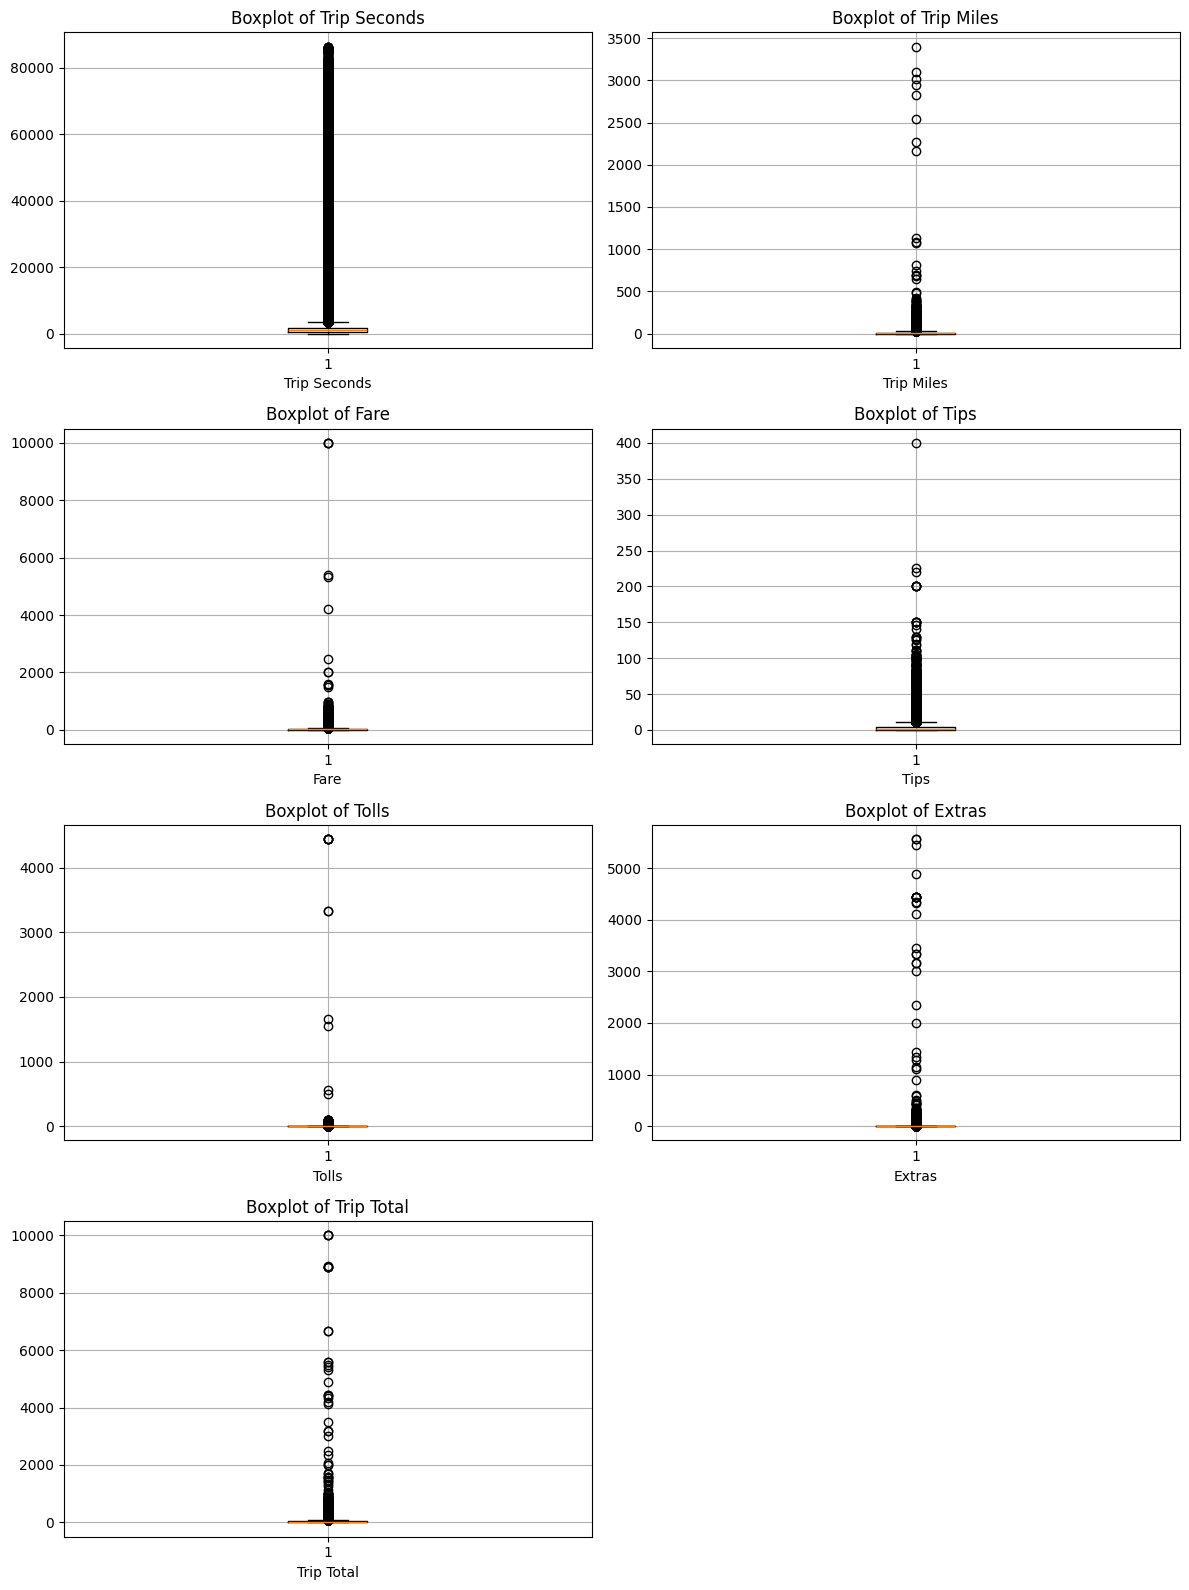

In [19]:
numeric_columns = ["Trip Seconds", "Trip Miles", "Fare", "Tips", "Tolls", "Extras", "Trip Total"]

# 2 plots per row
rows = math.ceil(len(numeric_columns) / 2)

fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    data = pd.to_numeric(full_df[col], errors='coerce').dropna()
    axes[i].boxplot(data, vert=True)
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)
    axes[i].grid(True)

# Remove any unused axes
for j in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [20]:
zscore_threshold = 2
outlier_indices_per_column = {}
all_outlier_indices = set()

# remove outliers based on z-score
for col in numeric_columns:
    # Replace zeros with NaN and filter out non-positive values
    safe_col = full_df[col].replace(0, np.nan)
    safe_col = safe_col[safe_col > 0]
    
    if safe_col.empty:
        continue
    
    # Log-transform and compute z-score
    log_transformed = np.log(safe_col)
    zscores = np.abs(zscore(log_transformed))
    zscore_series = pd.Series(zscores, index=log_transformed.index)

    # Find outliers
    outlier_indices = zscore_series[zscore_series > zscore_threshold].index
    outlier_indices_per_column[col] = list(outlier_indices)
    all_outlier_indices.update(outlier_indices)

    print(f"--> {len(outlier_indices)} outliers detected in '{col}'")

# Drop all outliers at once
df_cleaned = full_df.drop(index=all_outlier_indices).reset_index(drop=True)
print(f"\nOutlier detection completed. Total rows removed: {len(all_outlier_indices)}")

--> 235097 outliers detected in 'Trip Seconds'
--> 129755 outliers detected in 'Trip Miles'
--> 44858 outliers detected in 'Fare'
--> 60799 outliers detected in 'Tips'
--> 2366 outliers detected in 'Tolls'
--> 175436 outliers detected in 'Extras'
--> 89091 outliers detected in 'Trip Total'

Outlier detection completed. Total rows removed: 529967


# 1.5 Location Data Cleanup

In [21]:
tracts  = gpd.read_file("tl_2024_17_tract.geojson").to_crs(4326)

tract_centroids = (tracts.set_index("GEOID").geometry.centroid)

# checking for rows with coordinates and without tracts, to infer tracts
pickup_missing_tract = (full_df["Pickup Census Tract"].isna()
                 & full_df["Pickup Centroid Latitude"].notna()
                 & full_df["Pickup Centroid Longitude"].notna()
)


dropoff_missing_tract = (full_df["Dropoff Census Tract"].isna()
                 & full_df["Dropoff Centroid Latitude"].notna()
                 & full_df["Dropoff Centroid Longitude"].notna()
)

if pickup_missing_tract.any():
    pickup_points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(
            full_df.loc[pickup_missing_tract, "Pickup Centroid Longitude"],
            full_df.loc[pickup_missing_tract, "Pickup Centroid Latitude"],
            crs=4326
        ),
        index=full_df.index[pickup_missing_tract]
    )

if dropoff_missing_tract.any():
    dropoff_points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(
            full_df.loc[dropoff_missing_tract, "Dropoff Centroid Longitude"],
            full_df.loc[dropoff_missing_tract, "Dropoff Centroid Latitude"],
            crs=4326
        ),
        index=full_df.index[dropoff_missing_tract]
    )


pickup_joined = gpd.sjoin(pickup_points, tracts[["GEOID", "geometry"]], how="left", predicate="within")
full_df.loc[pickup_joined.index, "Pickup Census Tract"] = pickup_joined["GEOID"].values

dropoff_joined = gpd.sjoin(dropoff_points, tracts[["GEOID", "geometry"]], how="left", predicate="within")
full_df.loc[dropoff_joined.index, "Dropoff Census Tract"] = dropoff_joined["GEOID"].values

#checking for any rows with tracts and without coordinates and setting coordinates to center point of tract

pickup_missing_coords = (
    full_df["Pickup Census Tract"].notna()
    & full_df["Pickup Centroid Latitude"].isna()
    & full_df["Pickup Centroid Longitude"].isna()
)

dropoff_missing_coords = (
    full_df["Dropoff Census Tract"].notna()
    & full_df["Dropoff Centroid Latitude"].isna()
    & full_df["Dropoff Centroid Longitude"].isna()
)

if pickup_missing_coords.any():
    cent = tract_centroids.reindex(full_df.loc[pickup_missing_coords, "Pickup Census Tract"].astype(str))
    full_df.loc[pickup_missing_coords, "Pickup Centroid Latitude"] = cent.y.values
    full_df.loc[pickup_missing_coords, "Pickup Centroid Longitude"] = cent.x.values

if dropoff_missing_coords.any():
    cent = tract_centroids.reindex(full_df.loc[dropoff_missing_coords, "Dropoff Census Tract"].astype(str))
    full_df.loc[dropoff_missing_coords, "Dropoff Centroid Latitude"] = cent.y.values
    full_df.loc[dropoff_missing_coords, "Dropoff Centroid Longitude"] = cent.x.values


print(full_df.isnull().sum())


C:\Users\Anthony\AppData\Local\Temp\ipykernel_4840\482162790.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tract_centroids = (tracts.set_index("GEOID").geometry.centroid)
C:\Users\Anthony\AppData\Local\Temp\ipykernel_4840\482162790.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['17031062200' '17031062200' '17031980000' ... '17031839500' '17031980000'
 '17031030500']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  full_df.loc[pickup_joined.index, "Pickup Census Tract"] = pickup_joined["GEOID"].values
C:\Users\Anthony\AppData\Local\Temp\ipykernel_4840\482162790.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['17031081000' '1

Trip ID                            0
Taxi ID                            0
Trip Start Timestamp               0
Trip End Timestamp                 0
Trip Seconds                       0
Trip Miles                         0
Pickup Census Tract           307498
Dropoff Census Tract          799132
Pickup Community Area         139821
Dropoff Community Area        646565
Fare                               0
Tips                               0
Tolls                              0
Extras                             0
Trip Total                         0
Payment Type                       0
Company                            0
Pickup Centroid Latitude      138967
Pickup Centroid Longitude     138967
Pickup Centroid Location      138967
Dropoff Centroid Latitude     606202
Dropoff Centroid Longitude    606202
Dropoff Centroid  Location    606202
dtype: int64


In [22]:
full_df = full_df.dropna(subset=['Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area', 'Dropoff Community Area', 'Dropoff Census Tract', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude'])
print(full_df.isnull().sum())

Trip ID                       0
Taxi ID                       0
Trip Start Timestamp          0
Trip End Timestamp            0
Trip Seconds                  0
Trip Miles                    0
Pickup Census Tract           0
Dropoff Census Tract          0
Pickup Community Area         0
Dropoff Community Area        0
Fare                          0
Tips                          0
Tolls                         0
Extras                        0
Trip Total                    0
Payment Type                  0
Company                       0
Pickup Centroid Latitude      0
Pickup Centroid Longitude     0
Pickup Centroid Location      0
Dropoff Centroid Latitude     0
Dropoff Centroid Longitude    0
Dropoff Centroid  Location    0
dtype: int64


# Additional Features

In [23]:
# Calculate trip duration in seconds
full_df['Trip Duration'] = (full_df['Trip End Timestamp'] - full_df['Trip Start Timestamp']).dt.total_seconds()

C:\Users\Anthony\AppData\Local\Temp\ipykernel_4840\2120489599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['Trip Duration'] = (full_df['Trip End Timestamp'] - full_df['Trip Start Timestamp']).dt.total_seconds()


In [24]:
# Apply uber's h3 hexagonal distribution for pickup and dropoff locations
h3_resolution = 8
full_df['pickup_h3'] = full_df.apply(
    lambda row: h3.geo_to_h3(row['Pickup Centroid Latitude'], row['Pickup Centroid Longitude'], h3_resolution),
    axis=1
)

full_df['dropoff_h3'] = full_df.apply(
    lambda row: h3.geo_to_h3(row['Dropoff Centroid Latitude'], row['Dropoff Centroid Longitude'], h3_resolution),
    axis=1
)

C:\Users\Anthony\AppData\Local\Temp\ipykernel_4840\3300264249.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['pickup_h3'] = full_df.apply(
C:\Users\Anthony\AppData\Local\Temp\ipykernel_4840\3300264249.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['dropoff_h3'] = full_df.apply(


In [25]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6012738 entries, 0 to 7917843
Data columns (total 26 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip ID                     object        
 1   Taxi ID                     object        
 2   Trip Start Timestamp        datetime64[ns]
 3   Trip End Timestamp          datetime64[ns]
 4   Trip Seconds                float64       
 5   Trip Miles                  float64       
 6   Pickup Census Tract         object        
 7   Dropoff Census Tract        object        
 8   Pickup Community Area       float64       
 9   Dropoff Community Area      float64       
 10  Fare                        float64       
 11  Tips                        float64       
 12  Tolls                       float64       
 13  Extras                      float64       
 14  Trip Total                  float64       
 15  Payment Type                object        
 16  Company                

In [26]:
full_df.reset_index(drop=True)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Trip Duration,pickup_h3,dropoff_h3
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,2024-01-19 17:00:00,2024-01-19 18:00:00,4051.0,17.12,17031980000.0,17031320100.0,76.0,32.0,...,Flash Cab,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),3600.0,88275934edfffff,882664c1e3fffff
1,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,2024-01-05 09:00:00,2024-01-05 09:00:00,517.0,3.39,17031062200,17031081000,6.0,8.0,...,Taxicab Insurance Agency Llc,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),0.0,882664c163fffff,882664c1edfffff
2,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,2024-01-18 19:15:00,2024-01-18 19:30:00,1004.0,1.18,17031839100.0,17031839100.0,32.0,32.0,...,5 Star Taxi,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),900.0,882664c1a9fffff,882664c1a9fffff
3,0000cf293ada965f89a98c8ccfae7b0ce3a03e41,37073e8c9e454886fe4a916f80a9a3478570e7dd3e663f...,2024-01-04 07:15:00,2024-01-04 07:30:00,484.0,1.59,17031281900.0,17031320100.0,28.0,32.0,...,City Service,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),900.0,882664c1adfffff,882664c1e3fffff
4,0001235258d46a21317b6691ade9386c4d7e02c4,715b091e1001d1c17938c3b5ed7e23d926c53150ee2d0f...,2024-01-25 11:15:00,2024-01-25 11:30:00,1686.0,13.01,17031320100.0,17031980100.0,32.0,56.0,...,Chicago Independents,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.785999,-87.750934,POINT (-87.7509342894 41.785998518),900.0,882664c1e3fffff,8826645219fffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6012733,ffe34b33d8aed42a70688e643b0361cda328eee9,a70033840874630ef8ad8ee73cbdc43929011360ecc788...,2025-02-27 21:15:00,2025-02-27 22:00:00,2187.0,0.24,17031330100.0,17031330100.0,33.0,33.0,...,5 Star Taxi,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.859350,-87.617358,POINT (-87.6173580061 41.859349715),2700.0,882664c1b1fffff,882664c1b1fffff
6012734,ffe7f0345c09fd6775516c1812e02487830b8d61,f63196ed0c0996de34cb01b3a00e18b538f16a7eee12ce...,2025-02-27 08:45:00,2025-02-27 09:15:00,1878.0,8.91,17031030500,17031832900,77.0,28.0,...,Flash Cab,41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),41.874005,-87.663518,POINT (-87.6635175498 41.874005383),1800.0,882664d88bfffff,882664ca91fffff
6012735,fff3b5d6b8b2c8c63d4b21a761e8c787d60b9660,28c89d563fedfe61acff63dbafae9d908262e3150a2728...,2025-02-27 08:00:00,2025-02-27 08:15:00,557.0,1.68,17031281900.0,17031081500.0,28.0,8.0,...,Taxicab Insurance Agency Llc,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),900.0,882664c1adfffff,882664c1e1fffff
6012736,fffda738b0574f131754362760efccec7710b1c9,8cba51d644d2a96d874d93a5b0eb9cf26512383c2fdc5d...,2025-02-27 07:00:00,2025-02-27 07:00:00,294.0,0.53,17031280100.0,17031839100.0,28.0,32.0,...,Taxicab Insurance Agency Llc,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),0.0,882664c1adfffff,882664c1a9fffff


In [27]:
# store cleaned dataset in .csv
full_df.to_csv("Chicago_Trips.csv", index=False)